# Deep Learning Lab 1

PB20111689 蓝俊玮

In [28]:
import torch
import copy
import time
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from tqdm.auto import tqdm

define function:

In [29]:
def generate_dataset(num, test_size=0.2, random_state=1689):
    """ 生成数据集，并且划分出训练集和验证集，测试集，默认以8:2的比例划分
    :param num: 总数据集的大小
    :param test_size: 测试集的大小
    :random_state: 随机种子
    """
    X = torch.empty((num, 1), dtype=torch.float32).uniform_(1, 16)
    y = torch.log2(X) + torch.cos(torch.pi / 2 * X)
    X_, test_X, y_, test_y = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return (X_, y_), (test_X, test_y)

def show_init_func(X, y):
    """
    :param X: 函数定义域
    :param y: 函数值域
    """
    plt.title("function curves")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(X, y)

def show_pred_func(X, true_y, pred_y):
    """
    :param X: 函数定义域
    :param true_y: 函数真实值域
    :param pred_y: 函数预测值域
    """
    plt.title("function curves")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(X, torch.tensor(pred_y), label="pred_value")
    plt.scatter(X, true_y, label="true_value")
    plt.legend()

def crossvalid4_eval(estimator, X, y, lr=0.005, random_state=1689, verbose=True):
    """ 4折交叉训练并验证
    :param estimator: 需要使用的网络模型
    :param X: 目标数据集
    :param y: 数据集标签
    :param lr: 优化器的学习率
    :param random_state: 随机种子
    :param verbose:
    """

    kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
    avg_train_time = 0
    avg_valid_loss = 0

    for i, (train_index, valid_index) in enumerate(kf.split(X)):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = copy.deepcopy(estimator).to(device)
        model.device = device

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        n_epochs = 10
        batch_size = 32

        print("=== cross validation [%d] ===" %(i + 1))
        train_X, valid_X = X[train_index], X[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        train_dataset = Data.TensorDataset(train_X, train_y)
        train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
        train_losses = []
        start_time = time.time()
        for epoch in range(1, n_epochs + 1):
            model.train()
            train_loss = []
            for batch in train_loader:
                x, label = batch
                pred = model(x.to(device))
                loss = criterion(pred, label.to(device))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
            
            train_loss = sum(train_loss) / len(train_loss)
            train_losses.append(train_loss)
            if epoch % 5 == 0:
                print("epoch [%d], train MSE loss: [%f]" %(epoch, train_loss))
        end_time = time.time()
        avg_train_time += end_time - start_time
        
        valid_set = Data.TensorDataset(valid_X, valid_y)
        valid_loader = Data.DataLoader(valid_set, batch_size=1, shuffle=False)

        model.eval()
        valid_losses = []
        preds = []
        for batch in tqdm(valid_loader):
            x, true_y = batch
            with torch.no_grad():
                pred = model(x.to(device))
            loss = criterion(pred, true_y.to(device))
            valid_losses.append(loss)
            preds.append(pred)
        valid_loss = sum(valid_losses) / len(valid_losses)
        print("validation MSE loss: [%f]\n" %(valid_loss))
        avg_valid_loss += valid_loss

        if i + 1 == 4 and verbose:
            show_pred_func(valid_X, valid_y, preds)
    
    avg_train_time = avg_train_time / 4
    avg_valid_loss = avg_valid_loss / 4
    print("average training time: [%f], average validaiton loss: [%f]" %(avg_train_time, avg_valid_loss))
    return avg_train_time, avg_valid_loss, train_losses

In [30]:
class DNN(nn.Module):
    def __init__(self, layer=3, hidden_size=32, activation="relu"):
        super(DNN, self).__init__()
        input_size = 1
        output_size = 1
        self.dnn = nn.Sequential()

        self.activation = nn.ReLU()
        if activation == "sigmoid":
            self.activation = nn.Sigmoid()
        if activation == "tanh":
            self.activation = nn.Tanh()

        for i in range(1, layer + 1):
            if i == 1:
                self.dnn.add_module("hidden_layer1", nn.Linear(input_size, hidden_size))
                self.dnn.add_module(activation + str(i), self.activation)
                continue
            
            if i == layer:
                self.dnn.add_module("output_layer", nn.Linear(hidden_size, output_size))
                continue
            
            self.dnn.add_module("hidden_layer" + str(i), nn.Linear(hidden_size, hidden_size))
            self.dnn.add_module(activation + str(i), self.activation)
    
    def forward(self, x):
        x = self.dnn(x)
        return x


In [31]:
# generate dataset
(X_, y_), (test_X, test_y) = generate_dataset(num=100000)

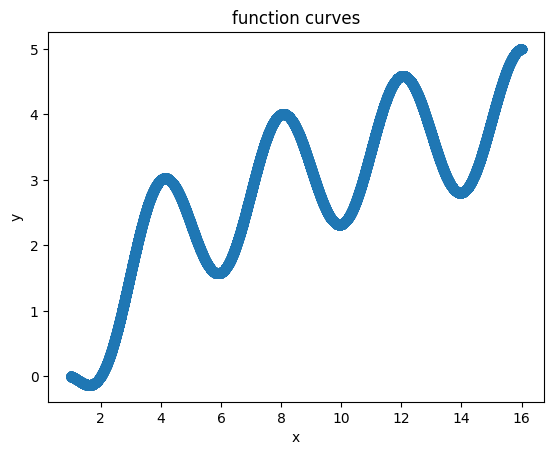

In [32]:
# show dataset function curves
show_init_func(X_, y_)

=== cross validation [1] ===
epoch [5], train MSE loss: [0.221640]
epoch [10], train MSE loss: [0.006297]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.003417]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.235606]
epoch [10], train MSE loss: [0.008368]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.004228]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.214517]
epoch [10], train MSE loss: [0.012942]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.027043]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.224940]
epoch [10], train MSE loss: [0.007212]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.003872]

average training time: [28.007891], average validaiton loss: [0.009640]


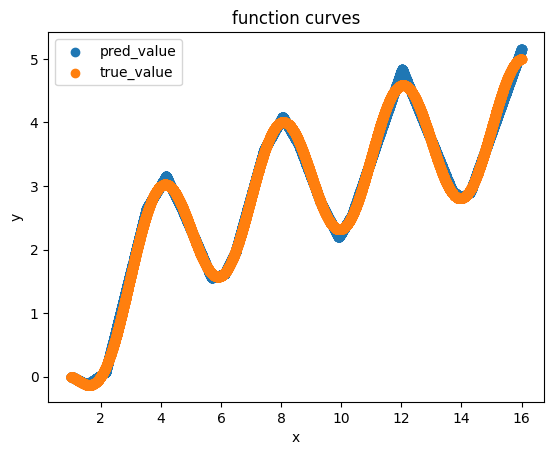

In [34]:
# default settings
default_train_time, default_valid_loss, default_train_loss = crossvalid4_eval(DNN(), X_, y_)

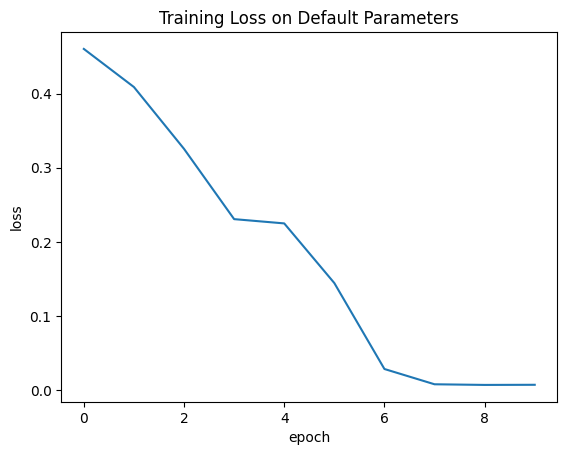

In [35]:
plt.title("Training Loss on Default Parameters")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(default_train_loss)

In [36]:
layers = [2, 4, 5]

best_layer = 3
min_layer_loss = default_valid_loss
layer_train_times = []
layer_valid_losses = []
layer_train_losses = []

for layer in layers:
    print("===== parameter layer: [%d] =====\n" %(layer))
    train_time, valid_loss, layer_train_loss = crossvalid4_eval(DNN(layer=layer), X_, y_, verbose=False)
    layer_train_times.append(train_time)
    layer_valid_losses.append(valid_loss)
    layer_train_losses.append(layer_train_loss)
    if valid_loss < min_layer_loss:
        min_layer_loss = valid_loss
        best_layer = layer

print("find best layer parameter: [%d]\n" %(best_layer))
print(layer_train_times)
print(layer_valid_losses)

===== parameter layer: [2] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.400756]
epoch [10], train MSE loss: [0.263587]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.245702]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.397708]
epoch [10], train MSE loss: [0.251186]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.242941]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.401541]
epoch [10], train MSE loss: [0.265962]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.245139]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.400905]
epoch [10], train MSE loss: [0.272931]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.240763]

average training time: [21.939305], average validaiton loss: [0.243636]
===== parameter layer: [4] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.156275]
epoch [10], train MSE loss: [0.004411]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.002313]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.226736]
epoch [10], train MSE loss: [0.003571]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.001365]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.138675]
epoch [10], train MSE loss: [0.002624]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.001934]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.007403]
epoch [10], train MSE loss: [0.005288]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.001931]

average training time: [32.171509], average validaiton loss: [0.001886]
===== parameter layer: [5] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.223771]
epoch [10], train MSE loss: [0.004494]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.003558]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.006570]
epoch [10], train MSE loss: [0.004146]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.002284]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.224005]
epoch [10], train MSE loss: [0.003685]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.001688]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.226827]
epoch [10], train MSE loss: [0.002151]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000403]

average training time: [37.874323], average validaiton loss: [0.001983]
find best layer parameter: [4]

[21.939304888248444, 32.17150926589966, 37.87432289123535]
[tensor(0.2436), tensor(0.0019), tensor(0.0020)]


In [37]:
hidden_sizes = [16, 64, 128]

best_hidden_size = 32
min_hidden_size_loss = default_valid_loss
hidden_size_train_times = []
hidden_size_valid_losses = []
hidden_size_train_losses = []

for hidden_size in hidden_sizes:
    print("===== parameter hidden_size: [%d] =====\n" %(hidden_size))
    train_time, valid_loss, hidden_size_train_loss = crossvalid4_eval(DNN(hidden_size=hidden_size), X_, y_, verbose=False)
    hidden_size_train_times.append(train_time)
    hidden_size_valid_losses.append(valid_loss)
    hidden_size_train_losses.append(hidden_size_train_loss)
    if valid_loss < min_hidden_size_loss:
        min_hidden_size_loss = valid_loss
        best_hidden_size = hidden_size

print("find best hidden_size parameter: [%d]\n" %(best_hidden_size))
print(hidden_size_train_times)
print(hidden_size_valid_losses)

===== parameter hidden_size: [16] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.272329]
epoch [10], train MSE loss: [0.254317]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.253697]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.274485]
epoch [10], train MSE loss: [0.220182]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.238772]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.276838]
epoch [10], train MSE loss: [0.257429]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.266725]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.240982]
epoch [10], train MSE loss: [0.097198]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.032390]

average training time: [27.513654], average validaiton loss: [0.197896]
===== parameter hidden_size: [64] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.122552]
epoch [10], train MSE loss: [0.004540]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.006655]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.058437]
epoch [10], train MSE loss: [0.006316]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.004209]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.007086]
epoch [10], train MSE loss: [0.004840]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.003445]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.009873]
epoch [10], train MSE loss: [0.007480]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.004503]

average training time: [29.813955], average validaiton loss: [0.004703]
===== parameter hidden_size: [128] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.025104]
epoch [10], train MSE loss: [0.003862]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.003522]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.010662]
epoch [10], train MSE loss: [0.004941]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.002256]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.027257]
epoch [10], train MSE loss: [0.004559]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.001582]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.031438]
epoch [10], train MSE loss: [0.003848]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.004314]

average training time: [35.681023], average validaiton loss: [0.002919]
find best hidden_size parameter: [128]

[27.5136536359787, 29.813955307006836, 35.68102341890335]
[tensor(0.1979), tensor(0.0047), tensor(0.0029)]


In [38]:
activations = ["sigmoid", "tanh"]

best_activation = "relu"
min_activation_loss = default_valid_loss
activation_train_times = []
activation_valid_losses = []
activation_train_losses = []

for activation in activations:
    print("===== parameter activation function: [%s] =====\n" %(activation))
    train_time, valid_loss, activation_train_loss = crossvalid4_eval(DNN(activation=activation), X_, y_, verbose=False)
    activation_train_times.append(train_time)
    activation_valid_losses.append(valid_loss)
    activation_train_losses.append(activation_train_loss)
    if valid_loss < min_activation_loss:
        min_activation_loss = valid_loss
        best_activation = activation

print("find best activation function parameter: [%s]\n" %(best_activation))
print(activation_train_times)
print(activation_valid_losses)

===== parameter activation function: [sigmoid] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.010590]
epoch [10], train MSE loss: [0.000754]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.001143]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.004979]
epoch [10], train MSE loss: [0.000596]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000141]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.019921]
epoch [10], train MSE loss: [0.000314]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000260]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.031459]
epoch [10], train MSE loss: [0.000599]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000065]

average training time: [27.090256], average validaiton loss: [0.000402]
===== parameter activation function: [tanh] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.001906]
epoch [10], train MSE loss: [0.003151]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000375]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.002415]
epoch [10], train MSE loss: [0.002701]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000477]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.002862]
epoch [10], train MSE loss: [0.002522]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000630]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.001868]
epoch [10], train MSE loss: [0.002586]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.000143]

average training time: [27.196217], average validaiton loss: [0.000406]
find best activation function parameter: [sigmoid]

[27.09025603532791, 27.196216642856598]
[tensor(0.0004), tensor(0.0004)]


In [39]:
lrs = [0.05, 0.01, 0.001]

best_lr = 0.005
min_lr_loss = default_valid_loss
lr_train_times = []
lr_valid_losses = []
lr_train_losses = []

for lr in lrs:
    print("===== parameter learning rate: [%f] =====\n" %(lr))
    train_time, valid_loss, lr_train_loss = crossvalid4_eval(DNN(), X_, y_, lr=lr, verbose=False)
    lr_train_times.append(train_time)
    lr_valid_losses.append(valid_loss)
    lr_train_losses.append(lr_train_loss)
    if valid_loss < min_lr_loss:
        min_lr_loss = valid_loss
        best_lr = lr

print("find best learning rate parameter: [%f]\n" %(best_lr))
print(lr_train_times)
print(lr_valid_losses)

===== parameter learning rate: [0.050000] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.233270]
epoch [10], train MSE loss: [0.205883]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.233605]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.239168]
epoch [10], train MSE loss: [0.234268]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.256277]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.278284]
epoch [10], train MSE loss: [0.277521]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.277362]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.241925]
epoch [10], train MSE loss: [0.241041]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.218265]

average training time: [27.724292], average validaiton loss: [0.246377]
===== parameter learning rate: [0.010000] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.022182]
epoch [10], train MSE loss: [0.010253]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.006185]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.228391]
epoch [10], train MSE loss: [0.224367]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.217257]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.067534]
epoch [10], train MSE loss: [0.014868]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.012150]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.230326]
epoch [10], train MSE loss: [0.226849]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.217440]

average training time: [27.715904], average validaiton loss: [0.113258]
===== parameter learning rate: [0.001000] =====

=== cross validation [1] ===
epoch [5], train MSE loss: [0.363050]
epoch [10], train MSE loss: [0.197980]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.188286]

=== cross validation [2] ===
epoch [5], train MSE loss: [0.268272]
epoch [10], train MSE loss: [0.229952]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.245712]

=== cross validation [3] ===
epoch [5], train MSE loss: [0.361734]
epoch [10], train MSE loss: [0.199852]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.186143]

=== cross validation [4] ===
epoch [5], train MSE loss: [0.368065]
epoch [10], train MSE loss: [0.227870]


  0%|          | 0/20000 [00:00<?, ?it/s]

validation MSE loss: [0.228048]

average training time: [27.296311], average validaiton loss: [0.212047]
find best learning rate parameter: [0.005000]

[27.724291622638702, 27.715903878211975, 27.296310663223267]
[tensor(0.2464), tensor(0.1133), tensor(0.2120)]


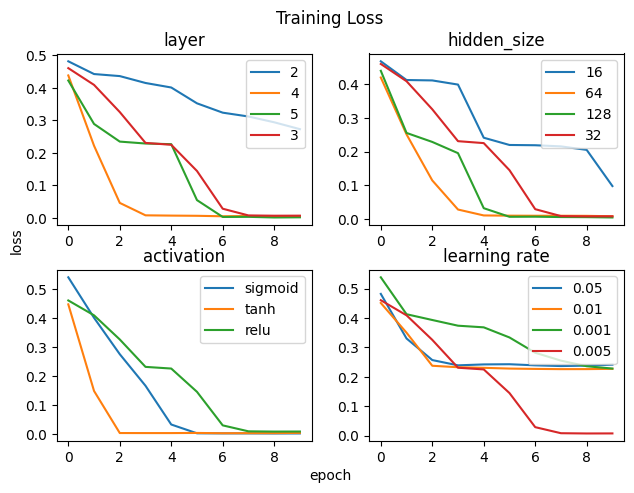

In [40]:
f, ax = plt.subplots(2, 2)
f.suptitle('Training Loss')
plt.tight_layout()

f.text(0.5, 0, 'epoch', ha='center')
f.text(0, 0.5, 'loss', va='center', rotation='vertical')

layer_str = [str(i) for i in layers]
layer_str.append("3")
layer_train_losses_copy = copy.deepcopy(layer_train_losses)
layer_train_losses_copy.append(default_train_loss)
ax[0][0].set_title('layer')
for i, label in enumerate(layer_str):
    ax[0][0].plot(layer_train_losses_copy[i], label=label)
ax[0][0].legend()

hidden_size_str = [str(i) for i in hidden_sizes]
hidden_size_str.append("32")
hidden_size_train_losses_copy = copy.deepcopy(hidden_size_train_losses)
hidden_size_train_losses_copy.append(default_train_loss)
ax[0][1].set_title('hidden_size')
for i, label in enumerate(hidden_size_str):
    ax[0][1].plot(hidden_size_train_losses_copy[i], label=label)
ax[0][1].legend()

activation_str = [str(i) for i in activations]
activation_str.append("relu")
activation_train_losses_copy = copy.deepcopy(activation_train_losses)
activation_train_losses_copy.append(default_train_loss)
ax[1][0].set_title('activation')
for i, label in enumerate(activation_str):
    ax[1][0].plot(activation_train_losses_copy[i], label=label)
ax[1][0].legend()

lr_str = [str(i) for i in lrs]
lr_str.append("0.005")
lr_train_losses_copy = copy.deepcopy(lr_train_losses)
lr_train_losses_copy.append(default_train_loss)
ax[1][1].set_title('learning rate')
for i, label in enumerate(lr_str):
    ax[1][1].plot(lr_train_losses_copy[i], label=label)
ax[1][1].legend()

<BarContainer object of 4 artists>

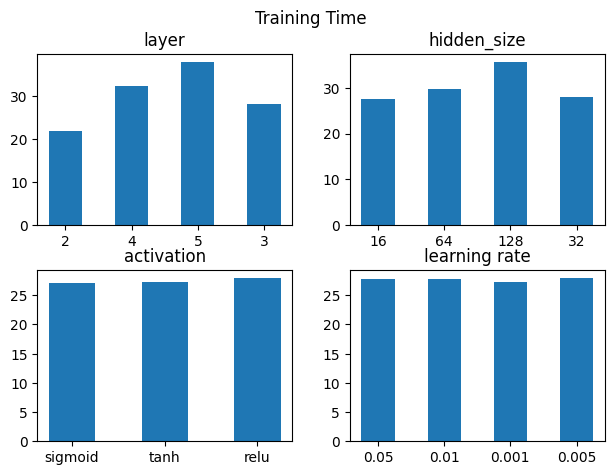

In [41]:
f, ax = plt.subplots(2, 2)
f.suptitle('Training Time')
plt.tight_layout()

layer_str = [str(i) for i in layers]
layer_str.append("3")
layer_train_times_copy = copy.deepcopy(layer_train_times)
layer_train_times_copy.append(default_train_time)
ax[0][0].set_title('layer')
ax[0][0].bar(layer_str, layer_train_times_copy, width=0.5)

hidden_size_str = [str(i) for i in hidden_sizes]
hidden_size_str.append("32")
hidden_size_train_times_copy = copy.deepcopy(hidden_size_train_times)
hidden_size_train_times_copy.append(default_train_time)
ax[0][1].set_title('hidden_size')
ax[0][1].bar(hidden_size_str, hidden_size_train_times_copy, width=0.5)

activation_str = [str(i) for i in activations]
activation_str.append("relu")
activation_train_times_copy = copy.deepcopy(activation_train_times)
activation_train_times_copy.append(default_train_time)
ax[1][0].set_title('activation')
ax[1][0].bar(activation_str, activation_train_times_copy, width=0.5)

lr_str = [str(i) for i in lrs]
lr_str.append("0.005")
lr_train_times_copy = copy.deepcopy(lr_train_times)
lr_train_times_copy.append(default_train_time)
ax[1][1].set_title('learning rate')
ax[1][1].bar(lr_str, lr_train_times_copy, width=0.5)

<BarContainer object of 4 artists>

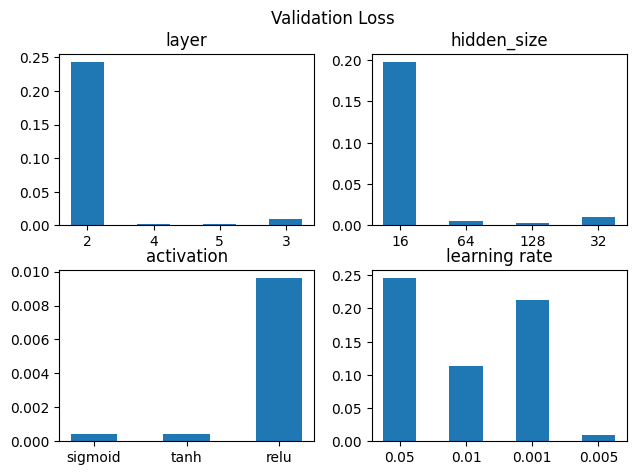

In [42]:
f, ax = plt.subplots(2, 2)
f.suptitle('Validation Loss')
plt.tight_layout()

layer_str = [str(i) for i in layers]
layer_str.append("3")
layer_valid_losses_copy = copy.deepcopy(layer_valid_losses)
layer_valid_losses_copy.append(default_valid_loss)
ax[0][0].set_title('layer')
ax[0][0].bar(layer_str, layer_valid_losses_copy, width=0.5)

hidden_size_str = [str(i) for i in hidden_sizes]
hidden_size_str.append("32")
hidden_size_valid_losses_copy = copy.deepcopy(hidden_size_valid_losses)
hidden_size_valid_losses_copy.append(default_valid_loss)
ax[0][1].set_title('hidden_size')
ax[0][1].bar(hidden_size_str, hidden_size_valid_losses_copy, width=0.5)

activation_str = [str(i) for i in activations]
activation_str.append("relu")
activation_valid_losses_copy = copy.deepcopy(activation_valid_losses)
activation_valid_losses_copy.append(default_valid_loss)
ax[1][0].set_title('activation')
ax[1][0].bar(activation_str, activation_valid_losses_copy, width=0.5)

lr_str = [str(i) for i in lrs]
lr_str.append("0.005")
lr_valid_losses_copy = copy.deepcopy(lr_valid_losses)
lr_valid_losses_copy.append(default_valid_loss)
ax[1][1].set_title('learning rate')
ax[1][1].bar(lr_str, lr_valid_losses_copy, width=0.5)

最终在测试集的预测结果如下：

layer: [4], hidden_size: [128], activation: [sigmoid], lr: [0.005000]



  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [1], train MSE loss: [0.326712]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [2], train MSE loss: [0.002513]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [3], train MSE loss: [0.004138]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [4], train MSE loss: [0.003016]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [5], train MSE loss: [0.002037]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [6], train MSE loss: [0.002731]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [7], train MSE loss: [0.002265]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [8], train MSE loss: [0.002314]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [9], train MSE loss: [0.002177]


  0%|          | 0/2500 [00:00<?, ?it/s]

epoch [10], train MSE loss: [0.001970]


  0%|          | 0/20000 [00:00<?, ?it/s]

test MSE loss: [0.000357]



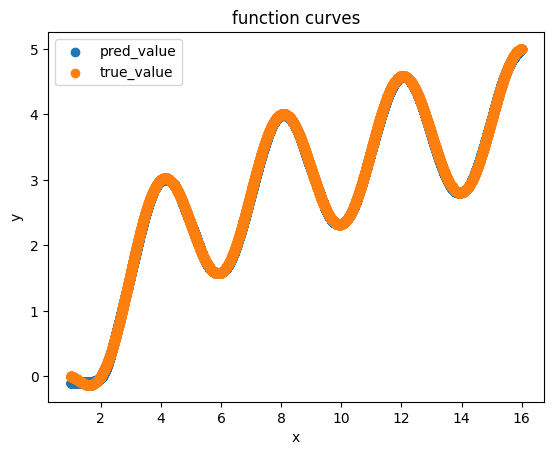

In [43]:
print("layer: [%d], hidden_size: [%d], activation: [%s], lr: [%f]\n" %(best_layer, best_hidden_size, best_activation, best_lr))

# retrain and validate on test dataset
device = "cuda" if torch.cuda.is_available() else "cpu"
# select best parameters
model = DNN(layer=best_layer, hidden_size=best_hidden_size, activation=best_activation).to(device)
model.device = device

criterion = nn.MSELoss()
# select best learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)

n_epochs = 10
batch_size = 32

train_dataset = Data.TensorDataset(X_, y_)
train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
for epoch in range(1, n_epochs + 1):
    model.train()
    train_loss = []
    for batch in tqdm(train_loader):
        x, label = batch
        pred = model(x.to(device))
        loss = criterion(pred, label.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    
    train_loss = sum(train_loss) / len(train_loss)
    print("epoch [%d], train MSE loss: [%f]" %(epoch, train_loss))

test_set = Data.TensorDataset(test_X, test_y)
test_loader = Data.DataLoader(test_set, batch_size=1, shuffle=False)

model.eval()
valid_losses = []
preds = []
for batch in tqdm(test_loader):
    x, true_y = batch
    with torch.no_grad():
        pred = model(x.to(device))
    loss = criterion(pred, true_y.to(device))
    valid_losses.append(loss)
    preds.append(pred)
valid_loss = sum(valid_losses) / len(valid_losses)
print("test MSE loss: [%f]\n" %(valid_loss))

show_pred_func(test_X, test_y, preds)